In [1]:
import time
start = time.time()

In [2]:
from sompz.functions_sompz import *
from sompz.functions_WL import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import yaml
import sys

## Files and global variables

In [3]:
# if len(sys.argv)==1:
#     cfgfile = 'y3_sompz.cfg'
# else:
# 	cfgfile = sys.argv[1]

cfgfile = 'y6_sompz.cfg'
with open(cfgfile, 'r') as fp:
    cfg = yaml.safe_load(fp)

In [4]:
deep_som_size = cfg['deep_som_size']
wide_som_size = cfg['wide_som_size']


n_bins = cfg['n_bins']
bin_edges =  cfg['bin_edges']

out_dir =  cfg['out_dir']
run_name = cfg['run_name']

balrog_file = cfg['balrog_file']
deep_balrog_file = cfg['deep_balrog_file']
deep_cells_assignment_balrog_file = cfg['deep_cells_assignment_balrog_file']
wide_cells_assignment_balrog_file = cfg['wide_cells_assignment_balrog_file']

########################## need to update ##################################
smooth_response_filename = cfg['smooth_response_filename']
cosmos_file = cfg['z_file']

wide_file = cfg['wide_file']
wide_cells_assignment_file = cfg['wide_cells_assignment_wide_file']

In [5]:
import os
os.system('mkdir -p {}'.format(out_dir))

0

In [6]:
# settings for output histogram - note that zbins_max needs to agree with Laigle currently
zbins_max = cfg['zbins_max']
zbins_dz  = cfg['zbins_dz']

# all z-bins above zmax_pileup will be piled into this last bin
# Can up or downweight the last bin
zmax_pileup = cfg['zmax_pileup']
zmax_weight = cfg['zmax_weight']

In [7]:
zbins  = np.arange(-zbins_dz/2.,zbins_max+zbins_dz,zbins_dz) # need to match Laigle binning if in 'usepz' mode
zmean  = (zbins[1:] + zbins[:-1])/2
fullpz = ["Z{:.2f}".format(s).replace(".","_") for s in np.arange(0,6.01,0.01)] # stays hardcoded while we use Laigle catalog as only truth

In [8]:
key      = fullpz
pointz   = 'Z'
keylabel = 'modal_even'

## Load cell assignment into dataframes for each dataset and calculate weights

In [9]:
balrog_data = build_balrog_df(deep_balrog_file, 
                    deep_cells_assignment_balrog_file, 
                    wide_cells_assignment_balrog_file)

balrog_data['overlap_weight'] = calculate_weights(smooth_response_filename, 
                                   balrog_data['unsheared/snr'], 
                                   balrog_data['unsheared/size_ratio'], 
                                   balrog_data["injection_counts"], 
                                   balrog_data['unsheared/weight'], 
                                   len(balrog_data))

Length of balrog_data: 1489859


In [10]:
spec_data = build_spec_df(cosmos_file, balrog_data)

n duplicated Laigle 36227
all cosmos deep:  601822
matched cosmos deep:  519660
unmatched cosmos deep:  82162


In [11]:
try:
    wide_data_assignment = pd.read_pickle(wide_cells_assignment_file)
except:
    wide_data_assignment = pd.read_csv(wide_cells_assignment_file, header=None, dtype =np.int32).rename(columns={0: 'cell_wide_unsheared'})

wide_data = build_wide_df(wide_file, wide_data_assignment)

read coadd_object_id done
read unsheared/fluxes done
read unsheared/snr done
read unsheared/T done
read unsheared/weight done


## Compute p(c | chat), p(z | c) and p(z | chat)

In [16]:
pcchat = calculate_pcchat(deep_som_size, 
                          wide_som_size,
                          balrog_data['cell_deep'].values,
                          balrog_data['cell_wide_unsheared'].values,       
                          balrog_data['overlap_weight'].values)

np.save(out_dir + '/' + 'pcchat.npy', pcchat)

In [17]:
all_deep_cells = np.arange(deep_som_size)

pz_c = np.array(get_deep_histograms(wide_data,
                                    spec_data,
                                    key=key,
                                    cells=all_deep_cells,
                                    overlap_weighted_pzc=True,
                                    bins=zbins))
np.save(out_dir + '/' + 'pzc.npy', pz_c)

In [18]:
all_wide_cells = np.arange(wide_som_size)

pz_chat = np.array(histogram(wide_data,
                             spec_data,
                             key=key,
                             pcchat = pcchat,
                             cells=all_wide_cells, 
                             cell_weights=np.ones(len(all_wide_cells)), 
                             overlap_weighted_pzc=True,
                             bins=zbins, 
                             individual_chat=True))

np.save(out_dir + '/' + 'pzchat.npy', pz_chat)

## Compute N(z)s 

In [19]:
# data into bins

tomo_bins_wide_dict = bin_assignment_spec(spec_data,
                                          deep_som_size,
                                          wide_som_size,
                                          bin_edges = bin_edges)

# tomo_bins_wide = tomo_bins_wide_2d(tomo_bins_wide_dict)

In [20]:
# bin occupation info

cell_occupation_info = wide_data.groupby('cell_wide_unsheared')['cell_wide_unsheared'].count()
bin_occupation_info = {'bin' + str(i) : np.sum(cell_occupation_info.loc[tomo_bins_wide_dict[i]].values) for i in range(n_bins)}
print(bin_occupation_info)

{'bin0': 37687150, 'bin1': 37220369, 'bin2': 37766153, 'bin3': 37420019}


In [21]:
# convert to format where tomo_bins_wide[i] is a 2D array, first column cell_id, second column an arbitrary weight
tomo_bins_wide = tomo_bins_wide_2d(tomo_bins_wide_dict)

In [22]:
# NOT_BIN_CONDITIONALIZED

hists_wide = redshift_distributions_wide(data = wide_data,
                                         deep_data = spec_data,
                                         overlap_weighted_pchat = True, 
                                         overlap_weighted_pzc = True, 
                                         bins = zbins,
                                         pcchat = pcchat,
                                         tomo_bins = tomo_bins_wide,
                                         key = key,
                                         force_assignment = False,
                                         cell_key = 'cell_wide_unsheared')

np.save(out_dir + '/' + 'hists_wide_NOT_BIN_CONDITIONALIZED_{}.npy'.format(keylabel), hists_wide)
plot_nz(hists_wide, zbins, out_dir + '/' + 'nz_newbinning_onwide_NOT_BIN_CONDITIONALIZED_{}.png'.format(keylabel))

In [23]:
# bin conditionalized n(z)

hists_wide_bin_cond = np.array([nz_bin_conditioned(wide_data, 
                                                   spec_data, 
                                                   overlap_weighted_pchat= True, 
                                                   overlap_weighted_pzc=True, 
                                                   tomo_cells=tomo_bins_wide[i], 
                                                   zbins=zbins, 
                                                   pcchat = pcchat, 
                                                   cell_wide_key='cell_wide_unsheared', 
                                                   zkey=key) for i in range(n_bins)])

np.save(out_dir + '/' + 'hists_wide_bin_conditionalized_{}.npy'.format(keylabel), hists_wide_bin_cond)
plot_nz(hists_wide_bin_cond, zbins, out_dir + '/' + 'nz_newbinning_onwide_bin_cond_{}.png'.format(keylabel))
plot_nz_overlap([hists_wide_bin_cond], [keylabel], out_dir + '/')

full redshift sample: 519660
subset of redshift sample in bin: 209623
full redshift sample: 519660
subset of redshift sample in bin: 121294
full redshift sample: 519660
subset of redshift sample in bin: 128074
full redshift sample: 519660
subset of redshift sample in bin: 60669


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## Pile up very high z

In [24]:
zbins_piled, zmean_piled, hists_wide_bin_cond_piled = pileup(hists_wide_bin_cond,
                                                             zbins,
                                                             zmean,
                                                             zmax_pileup,
                                                             zbins_dz,
                                                             zmax_weight,
                                                             n_bins)

means_bc_piled, sigmas_bc_piled = get_mean_sigma(zmean_piled, hists_wide_bin_cond_piled)

np.save(out_dir + '/' + 'hists_wide_bin_conditionalized_pileup3_{}.npy'.format(keylabel), hists_wide_bin_cond_piled)
plot_nz(hists_wide_bin_cond_piled, zbins_piled, out_dir + '/' + 'nz_newbinning_onwide_bincond_pilledup_{}.png'.format(keylabel))


save_des_nz(hists_wide_bin_cond_piled,
            zbins_piled,
            n_bins,
            out_dir + '/',
            run_name,
            keylabel +'_bincond_pileup3') ##THIS IS THE NZ WE USE

Dz, new-end-z,weight:  0.01 3.0 1.0
mkdir -p /global/cfs/cdirs/des/acampos/sompz_output/y6_data_preliminary_v2/
write /global/cfs/cdirs/des/acampos/sompz_output/y6_data_preliminary_v2/redshift_distributions_y6_test_v2_modal_even_bincond_pileup3.fits


## Smooth

In [25]:
# write nzs into an existing 2pts fits file 

template_fits='/global/cfs/projectdirs/des/acampos/cosmosis/cosmosis-des-library/y3-3x2pt-final/data/des-y3/2pt_NG_final_2ptunblind_02_24_21_wnz_covupdate.v2.fits'
file_nzs = out_dir + '/' + f'redshift_distributions_{run_name}_modal_even_bincond_pileup3.fits'
out_file_non_smooth = out_dir + '/' + f'2pt_{keylabel}_{run_name}_non_smooth.fits'

to2point(out_file_non_smooth,
         file_nzs,
         template_fits,
         run_name,
         keylabel,
         out_dir)

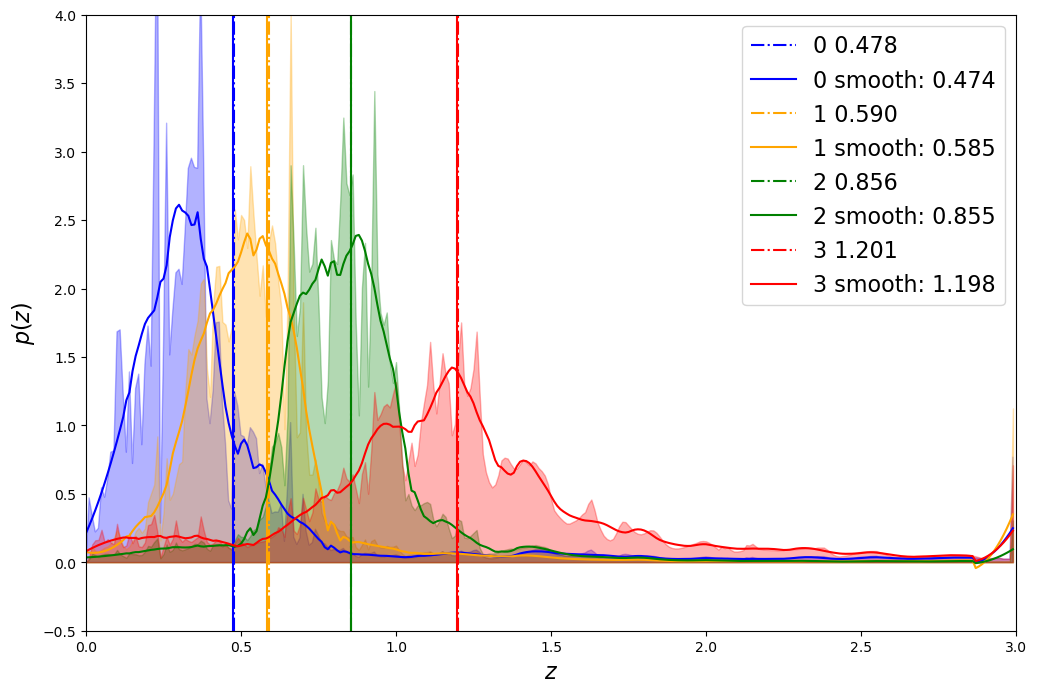

In [26]:
# Smooth 

file_nzs_smooth = out_dir + '/' + f'redshift_distributions_{keylabel}_{run_name}_bincond_pileup3_smooth.txt'
out_file_smooth = out_dir + '/' + f'2pt_{keylabel}_{run_name}_smooth.fits'

smooth(out_file_smooth,
       out_file_non_smooth,
       file_nzs_smooth,
       run_name,
       keylabel,
       out_dir + '/',
       hists_wide_bin_cond_piled)

#END smooth

## Generate h5 file

In [27]:
# convert to DF with cell <-> bin relation
tmp_cells = np.concatenate([tomo_bins_wide[nbin][:,0] for nbin in tomo_bins_wide])
tmp_bins = np.concatenate([(np.ones(len(tomo_bins_wide[nbin][:,0])) * nbin).astype(int) for 
                           nbin in tomo_bins_wide])
tomo_bin_hashtable = pd.Series(tmp_bins, tmp_cells)

nrows = wide_data['coadd_object_id'].shape[0]

In [28]:
f = h5py.File(out_dir + '/' + 'sompz_test.hdf5','w', track_order=True)

In [29]:
# fluxtypes = ['unsheared', 'sheared_1m', 'sheared_1p', 'sheared_2m', 'sheared_2p']
fluxtypes = ['unsheared']

# add binning info to catalog
for fluxtype in fluxtypes:
    if fluxtype == 'unsheared':
        f.create_dataset('catalog/sompz/unsheared/coadd_object_id', data = wide_data['coadd_object_id'])
    
    print('add binning {}'.format(fluxtype))
    try:
        f.create_dataset(f'catalog/sompz/{fluxtype}/bhat', 
                         maxshape=(nrows,),
                         shape=(nrows,), dtype='i8')
        print("that worked!")
    except Exception as e:
        print(e)
    tmp = wide_data['cell_wide_{}'.format(fluxtype)].map(tomo_bin_hashtable)
    tmp[np.isnan(tmp)] = -1
    f['catalog/sompz/{}/bhat'.format(fluxtype)][...] = tmp
    f.create_dataset(f'catalog/sompz/{fluxtype}/cell_wide', data = wide_data[f'cell_wide_{fluxtype}'])
    


add binning unsheared
that worked!


In [30]:
f.create_dataset('catalog/sompz/pzdata/pz_c', data = pz_c)
print(f['catalog/sompz/pzdata/pz_c'][...].shape)

(4096, 601)


In [31]:
f.create_dataset('catalog/sompz/pzdata/pz_chat', data = pz_chat)
print(f['catalog/sompz/pzdata/pz_chat'][...].shape)

(1024, 601)


In [32]:
nz = fitsio.read(out_dir + '/' + 'redshift_distributions_y6_test_v2_modal_even_bincond_pileup3.fits')

In [33]:
f.create_dataset('catalog/sompz/pzdata/bin0',  data = nz['BIN1'])
f.create_dataset('catalog/sompz/pzdata/bin1',  data = nz['BIN2'])
f.create_dataset('catalog/sompz/pzdata/bin2',  data = nz['BIN3'])
f.create_dataset('catalog/sompz/pzdata/bin3',  data = nz['BIN4'])
f.create_dataset('catalog/sompz/pzdata/zhigh', data = nz['Z_HIGH'])
f.create_dataset('catalog/sompz/pzdata/zlow',  data = nz['Z_LOW'])

<HDF5 dataset "zlow": shape (300,), type ">f8">

In [34]:
f.close()

In [35]:
end = time.time()
print(end - start)

731.8726739883423
